In [1]:
# This notebook addresses class imbalance in the image classification project using:
# - Class weighting
# - Basic data augmentation
# - Optional GPU acceleration on Mac via `MAC_MODE`
# - Visualization of accuracy and loss


In [2]:
import os
import time

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
# Toggle for local Mac GPU support
MAC_MODE = True  # Set to False for Windows/Linux

if MAC_MODE:
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    print("Mac mode enabled (Metal acceleration will be used if available).")
    print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
else:
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print(f"Using GPU: {physical_devices[0].name}")
    else:
        print("No GPU found. Running on CPU.")


Mac mode enabled (Metal acceleration will be used if available).
Num GPUs Available: 1


In [4]:
def data_augmentation(): 
    data_dir = "data_split"
    train_dir = os.path.join(data_dir, "train")
    test_dir = os.path.join(data_dir, "test")

    image_size = (224, 224)
    batch_size = 32

    train_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    ).flow_from_directory(
        train_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical'
    )

    test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical'
    )

    return train_gen, test_gen


In [5]:
def get_class_weights(train_gen):    
    counts = train_gen.classes
    weights = compute_class_weight(class_weight="balanced", classes=np.unique(counts), y=counts)
    class_weights = dict(zip(np.unique(counts), weights))
    print("Computed class weights:", class_weights)

    return class_weights


In [10]:
def run_training(train_gen, test_gen, class_weights, stage=1, data_dir="data_split", image_size=(224, 224), batch_size=32):
    """
    Run staged fine-tuning with ResNet50 and visualize results.
    
    Parameters:
    - stage: 1, 2, or 3
    - data_dir: must contain 'train' and 'test' subdirs
    - image_size: tuple (H, W)
    - batch_size: int

    Returns:
    - model: final trained model
    """
    print(f"tarting {stage}-stage training")

    

    # Model
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(*image_size, 3))
    model = Sequential([base_model, GlobalAveragePooling2D(), Dense(3, activation="softmax")])

    def plot_history(history, label):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(1, len(acc) + 1)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, 'bo-', label='Train')
        plt.plot(epochs, val_acc, 'ro-', label='Val')
        plt.title(f'{label} - Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, 'bo-', label='Train')
        plt.plot(epochs, val_loss, 'ro-', label='Val')
        plt.title(f'{label} - Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


    #history_all = []

    # STAGE 1: Train top layers only
    if stage >= 1:
        print("Stage 1: training top layers (frozen base)")
        base_model.trainable = False
        model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
        hist = model.fit(train_gen, validation_data=test_gen, epochs=3, class_weight=class_weights)
        #history_all.append(hist)
        plot_history(hist, "Stage 1")

    # STAGE 2: Fine-tune last 30 layers
    if stage >= 2:
        print("Stage 2: fine-tuning last 30 layers")
        base_model.trainable = True
        for layer in base_model.layers[:-30]:
            layer.trainable = False
        model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
        hist = model.fit(train_gen, validation_data=test_gen, epochs=5, class_weight=class_weights)
        #history_all.append(hist)
        plot_history(hist, "Stage 2")

    # STAGE 3: Fine-tune full model
    if stage >= 3:
        print("Stage 3: full model fine-tuning")
        for layer in base_model.layers:
            layer.trainable = True
        model.compile(optimizer=Adam(1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
        hist = model.fit(train_gen, validation_data=test_gen, epochs=5, class_weight=class_weights)
        #history_all.append(hist)
        plot_history(hist, "Stage 3")

    # Confusion matrix on test set
    print("Final Confusion Matrix:")
    y_true = test_gen.classes
    y_pred = np.argmax(model.predict(test_gen), axis=1)
    labels = list(test_gen.class_indices.keys())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues')
    plt.xticks(rotation=20)
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

    return model


## Transfer Learning and Timing

tarting 1-stage training
Found 4007 images belonging to 3 classes.
Found 1861 images belonging to 3 classes.
Computed class weights: {0: 6.742753623188406, 1: 3.714570858283433, 2: 0.38722430295464005}
Stage 1: training top layers (frozen base)


/Users/daniel/miniconda3/envs/data_engineering/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
126/126 ━━━━━━━━━━━━━━━━━━━━ 30s 210ms/step - accuracy: 0.2067 - loss: 1.1581 - val_accuracy: 0.0720 - val_loss: 1.1652
Epoch 2/3
126/126 ━━━━━━━━━━━━━━━━━━━━ 24s 189ms/step - accuracy: 0.1672 - loss: 1.1184 - val_accuracy: 0.1510 - val_loss: 1.1541
Epoch 3/3
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 185ms/step - accuracy: 0.3568 - loss: 1.0906 - val_accuracy: 0.6034 - val_loss: 0.9946


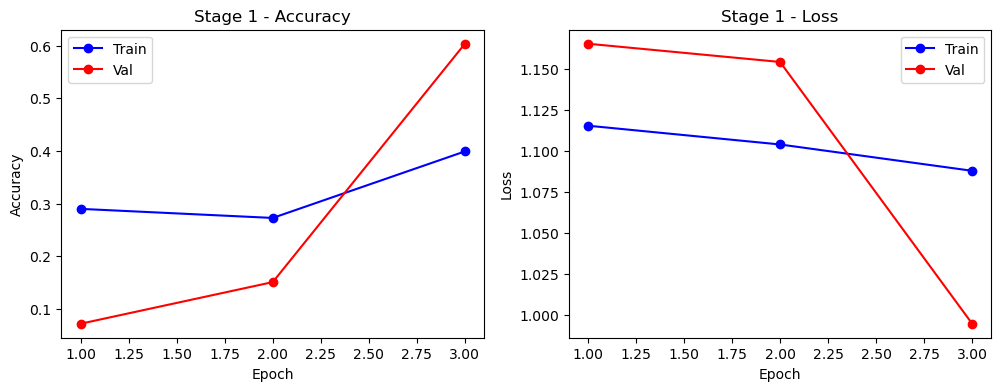

Final Confusion Matrix:
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step


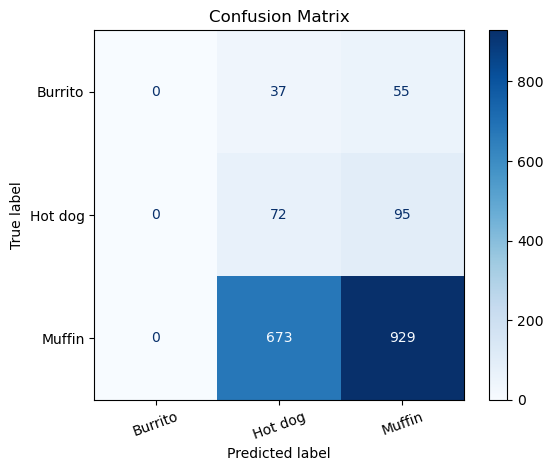

Training time: 87.23 seconds


In [ ]:
train_gen, test_gen = data_augmentation()
class_weights = get_class_weights(test_gen)


start = time.time()
model = run_training(train_gen, test_gen, class_weights, stage=1)
print("Training time:", round(time.time() - start, 2), "seconds")

## Inference Time and Used Hardware

In [11]:
print("Device:", tf.config.list_physical_devices())


start = time.time()
model.predict(test_gen, verbose=1)
print("Inference time on test set:", round(time.time() - start, 2), "seconds")

Device: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 4007 images belonging to 3 classes.
Found 1861 images belonging to 3 classes.


/Users/daniel/miniconda3/envs/data_engineering/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step
Inference time on test set: 4.42 seconds


## Model Parameters

In [43]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │         6,147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,675,339 (269.61 MB)

 Trainable params: 23,540,739 (89.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 47,081,480 (179.60 MB)

## Categories most confused
- The model most frequently confused all classes with "muffin", as clearly shown in the confusion matrix. This is due to severe data imbalance.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

def get_img_array(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array / 255.0

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Extract ResNet50 base
    base_model = model.layers[0]  # assuming ResNet50 is first in Sequential
    
    # Get conv layer
    conv_layer = base_model.get_layer(last_conv_layer_name)

    # Build model from ResNet input to conv output & full model output
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = model.layers[1](x)  # GAP
    output = model.layers[2](x)  # Dense
    grad_model = Model(inputs=inputs, outputs=[conv_layer.output, output])

    # Forward pass + tape
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy(), pred_index.numpy()



def display_gradcam(img_path, model, class_names, last_conv_layer="conv5_block3_out", image_size=(224,224)):
    img_array = get_img_array(img_path, image_size)
    heatmap, pred_index = make_gradcam_heatmap(img_array, model, last_conv_layer)

    # Original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, image_size)
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

    # Show result
    pred_label = class_names[pred_index]
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM: {pred_label}")
    plt.axis("off")
    plt.show()


In [20]:


class_names = list(test_gen.class_indices.keys())
display_gradcam("additional_images/burrito.jpeg", model, class_names)


KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m13528662368\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=array([[[[0.84705883, 0.827451  , 0.8156863 ],\n         [0.8509804 , 0.83137256, 0.81960785],\n         [0.8509804 , 0.83137256, 0.81960785],\n         ...,\n         [0.84313726, 0.8235294 , 0.8117647 ],\n         [0.84313726, 0.8235294 , 0.8117647 ],\n         [0.84313726, 0.8235294 , 0.8117647 ]],\n\n        [[0.84705883, 0.827451  , 0.8156863 ],\n         [0.8509804 , 0.83137256, 0.81960785],\n         [0.8509804 , 0.83137256, 0.81960785],\n         ...,\n         [0.84313726, 0.8235294 , 0.8117647 ],\n         [0.84313726, 0.8235294 , 0.8117647 ],\n         [0.84313726, 0.8235294 , 0.8117647 ]],\n\n        [[0.84705883, 0.827451  , 0.8156863 ],\n         [0.8509804 , 0.83137256, 0.81960785],\n         [0.8509804 , 0.83137256, 0.81960785],\n         ...,\n         [0.84313726, 0.8235294 , 0.8117647 ],\n         [0.84313726, 0.8235294 , 0.8117647 ],\n         [0.84313726, 0.8235294 , 0.8117647 ]],\n\n        ...,\n\n        [[0.94509804, 0.827451  , 0.7176471 ],\n         [0.94509804, 0.827451  , 0.7176471 ],\n         [0.9372549 , 0.83137256, 0.7176471 ],\n         ...,\n         [0.9490196 , 0.827451  , 0.7058824 ],\n         [0.9372549 , 0.8156863 , 0.69411767],\n         [0.9372549 , 0.8156863 , 0.69411767]],\n\n        [[0.94509804, 0.827451  , 0.7176471 ],\n         [0.94509804, 0.827451  , 0.7176471 ],\n         [0.9372549 , 0.83137256, 0.7176471 ],\n         ...,\n         [0.9529412 , 0.83137256, 0.70980394],\n         [0.9372549 , 0.8156863 , 0.69411767],\n         [0.9372549 , 0.8156863 , 0.69411767]],\n\n        [[0.94509804, 0.827451  , 0.7176471 ],\n         [0.94509804, 0.827451  , 0.7176471 ],\n         [0.9372549 , 0.83137256, 0.7176471 ],\n         ...,\n         [0.9411765 , 0.81960785, 0.69803923],\n         [0.9372549 , 0.8156863 , 0.69411767],\n         [0.9372549 , 0.8156863 , 0.69411767]]]], dtype=float32)\n  • training=None\n  • mask=None'